In [3]:
!pip3 install scikit-learn
!pip3 install torch
!pip3 install torchinfo


In [ ]:
!pip3 install google-colab

In [225]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection, InstanceHardnessThreshold, NearMiss, ClusterCentroids
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns


In [226]:
'''CONFIG FOR LOCAL / CLOUD RUNNING'''
running_local = 'content' not in os.getcwd()
if running_local:
    path = ''
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path = 'drive/MyDrive/StructuralBioinformatics/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [227]:
# RUN ONLY TO REBUILD DATASET CSV
#dfs = []
#for filename in os.listdir('features_ring'):
#    if filename[-4:] == '.tsv':
#        dfs.append(pd.read_csv('features_ring/' + filename, sep='\t'))
#df = pd.concat(dfs)
#df

In [228]:
# don't need to execute - only to export df for training in cloud
#df.to_csv('contact_df.csv')

In [230]:
df = pd.read_csv(path + 'data/contact_df.csv')
df = df[df.Interaction.notna()]
di = {"HBOND": 0, "IONIC": 1, "PICATION": 2, "PIPISTACK": 3, "SSBOND": 4, "VDW": 5}
y = df['Interaction']
cat_names = list(y.astype('category').cat.categories)
y = y.replace(di)
y_oneHot = pd.get_dummies(y)
X = df[['s_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]


In [231]:
sfm = SelectFromModel(LogisticRegression(max_iter=1000))
sfm.fit(X, y)
X = sfm.transform(X)
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [172]:
# Create the test and train split (from ORIGINAL data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, stratify=y, random_state=123)
# TO FIX: WE NEED A VALIDATION SET THAT IS NOT AFFECTED BY THE PREPROCESSING!
# For now, I'm using the test set with a constraint on the indexes in the training function to use as a validation set, but we need a better solution.

n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True)

In [232]:
# Preprocessing TRAIN DATA ONLY
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Undersampling data...")
undersample = InstanceHardnessThreshold(estimator=AdaBoostClassifier(),sampling_strategy={0:50000,5:50000})
X_train, y_train = undersample.fit_resample(X_train, y_train)

print("Oversampling data...")
oversample = SMOTE(sampling_strategy={1:50000,3:50000,2:50000,4:50000})
X_train, y_train = oversample.fit_resample(X_train, y_train)

Undersampling data...
Oversampling data...


In [233]:
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=16000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16000)

In [175]:
y_arg = np.argmax(y_oneHot.values, axis=1)
y_arg_processed = np.argmax(y_train, axis=1)
_, count = np.unique(y_arg, return_counts=True)
class_count = dict(zip(cat_names, count))
_, count_processed = np.unique(y_arg_processed, return_counts=True)
class_count_processed = dict(zip(cat_names, count_processed))

fig, ax = plt.subplots()
x = np.arange(len(cat_names))  # label locations
width = 0.35  # width of the bars
rects1 = ax.bar(x - width/2, count, width, label='Orginal')
rects2 = ax.bar(x + width/2, count_processed, width, label='Preprocessed')

# Add labels, title, and legend
ax.set_ylabel('Examples')
ax.set_ylabel('Contact type')
ax.set_title('Number of contacts by bond type')
ax.set_xticks(x)
ax.set_xticklabels(cat_names)
ax.legend()

plt.show()

AxisError: ignored

In [251]:
'''GOOBLIN'''
class ContactNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
        super().__init__()
        self.layers = nn.ModuleList()

        if len(hidden_layers_dim) == 0:
            self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(hidden_layers_dim)):
                if layer_idx == 0:  # first layer, from input to hidden
                    self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
            self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        if x.dtype != torch.float32:
            x = x.float()

        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)  # the output of the last layer


input_size = X.shape[1]  # The number of input features
num_classes = y_oneHot.shape[1]  # The number of output classes

model = ContactNet(input_size, num_classes, [128, 256, 256, 256])

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [240]:
'''class ContactNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
        super().__init__()
        self.layers = nn.ModuleList()
        if len(hidden_layers_dim) == 0:
            self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(hidden_layers_dim)):
                if layer_idx == 0:  # first layer, from input to hidden
                    self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
            self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
        self.apply(self._init_weights)'''
class ContactNet(nn.Module):
  '''def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
    super().__init__()
    self.layers = nn.ModuleList()
    if len(hidden_layers_dim) == 0:
      self.layers.append(nn.Linear(input_dim, num_classes))
    else:
      for layer_idx in range(len(hidden_layers_dim)):
        if layer_idx == 0:  # first layer, from input to hidden
          self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
        else:  # hidden layers, depending on the input
          self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
      self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
    self.apply(self._init_weights)'''
  def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
    super().__init__()
    self.layers = nn.ModuleList()

    if len(hidden_layers_dim) == 0:
      self.layers.append(nn.Linear(input_dim, num_classes))
      self.layers.append(nn.Softmax(dim=1))  # Add softmax activation
    else:
      for layer_idx in range(len(hidden_layers_dim)):
        if layer_idx == 0:  # first layer, from input to hidden
          self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
          self.layers.append(nn.ReLU())  # Add activation function (e.g., ReLU)
        else:  # hidden layers, depending on the input
          self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
          self.layers.append(nn.ReLU())  # Add activation function (e.g., ReLU)
      self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
      self.layers.append(nn.Softmax(dim=1))  # Add softmax activation
    self.apply(self._init_weights)


  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=.1)
      if module.bias is not None:
        module.bias.data.zero_()

  def forward(self, x):
    if not isinstance(x, torch.Tensor):
      x = torch.Tensor(x)
    if x.dtype != torch.float32:
      x = x.float()
    if len(self.layers) == 1:
      return self.layers[0](x)
    else:
      for layer in self.layers[:-1]:
        x = F.relu(layer(x))
    return F.log_softmax(x, dim=1)#self.layers[-1](x)


input_size = X.shape[1]  # The number of input features
num_classes = y_oneHot.shape[1] # The number of output classes

model = ContactNet(input_size, num_classes, [128, 256, 256, 256])

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model)

Layer (type:depth-idx)                   Param #
ContactNet                               --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33,024
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       65,792
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       65,792
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       1,542
│    └─Softmax: 2-10                     --
Total params: 167,046
Trainable params: 167,046
Non-trainable params: 0

In [249]:
def train_min(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch+1}/{epochs} - Train Loss: {loss.item():.5f}")



In [239]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_auc_history = []

    for epoch in range(epochs):
        train_losses = []
        train_accuracies = []
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            accuracy = (preds == labels).sum().item() / len(labels)
            train_accuracies.append(accuracy)

        val_loss, val_accuracy, val_auc = validate(model, val_loader)

        train_loss_history.append(np.mean(train_losses))
        train_accuracy_history.append(np.mean(train_accuracies))
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)
        val_auc_history.append(val_auc)

        print(f"Epoch: {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.5f} - Train Accuracy: {train_accuracies[-1]:.5f} - Val Loss: {val_loss:.5f} - Val Accuracy: {val_accuracy:.5f} - Val AUC: {val_auc:.5f}")

    return {
        'train_loss': train_loss_history,
        'train_accuracy': train_accuracy_history,
        'val_loss': val_loss_history,
        'val_accuracy': val_accuracy_history,
        'val_auc': val_auc_history
    }


In [236]:
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    val_auc = 0.0
    val_accuracy = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)  # Move inputs to GPU if available
            labels = labels.to(device)  # Move labels to GPU if available

            val_outputs = model(inputs)
            val_probs = torch.softmax(val_outputs, dim=1)
            val_loss += criterion(val_outputs, labels).item()

            _, preds = torch.max(val_probs, 1)
            val_auc += roc_auc_score(labels.cpu().numpy(), val_probs.cpu().numpy(), multi_class='ovr')
            val_accuracy += (preds == labels).sum().item()

            num_batches += 1

    val_loss /= num_batches
    val_auc /= num_batches
    val_accuracy /= len(val_loader.dataset)

    return val_loss, val_auc, val_accuracy


In [162]:
def validate(model, val_loader):
  model.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      val_outputs = torch.softmax(model(X_test), dim=1).detach()
      val_loss = criterion(val_outputs, labels)
      _, preds = torch.max(val_outputs, 1)
      val_auc = roc_auc_score(labels.numpy(), val_outputs.numpy(), multi_class='ovr')
  return val_loss.item(), val_auc

In [ ]:
def kf_train

In [252]:
train_min(model, train_loader, test_loader, criterion, optimizer, epochs=30)

Epoch: 1/30 - Train Loss: 0.73132
Epoch: 2/30 - Train Loss: 0.33426
Epoch: 3/30 - Train Loss: 0.25977
Epoch: 4/30 - Train Loss: 0.23982
Epoch: 5/30 - Train Loss: 0.23408
Epoch: 6/30 - Train Loss: 0.23249
Epoch: 7/30 - Train Loss: 0.23561
Epoch: 8/30 - Train Loss: 0.22692
Epoch: 9/30 - Train Loss: 0.22908
Epoch: 10/30 - Train Loss: 0.22701
Epoch: 11/30 - Train Loss: 0.23014
Epoch: 12/30 - Train Loss: 0.23265
Epoch: 13/30 - Train Loss: 0.22304
Epoch: 14/30 - Train Loss: 0.22598
Epoch: 15/30 - Train Loss: 0.22530
Epoch: 16/30 - Train Loss: 0.22911
Epoch: 17/30 - Train Loss: 0.22697
Epoch: 18/30 - Train Loss: 0.23008
Epoch: 19/30 - Train Loss: 0.22071
Epoch: 20/30 - Train Loss: 0.22779
Epoch: 21/30 - Train Loss: 0.22807
Epoch: 22/30 - Train Loss: 0.22565
Epoch: 23/30 - Train Loss: 0.22815
Epoch: 24/30 - Train Loss: 0.22054
Epoch: 25/30 - Train Loss: 0.22445
Epoch: 26/30 - Train Loss: 0.22399
Epoch: 27/30 - Train Loss: 0.22670
Epoch: 28/30 - Train Loss: 0.22551
Epoch: 29/30 - Train Loss: 0.

In [243]:
hist = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=30)

Epoch: 1/30 - Train Loss: 0.77995 - Train Accuracy: 0.72555 - Val Loss: 1.53862 - Val Accuracy: 0.82259 - Val AUC: 0.39037
Epoch: 2/30 - Train Loss: 0.34066 - Train Accuracy: 0.84050 - Val Loss: 1.78431 - Val Accuracy: 0.83651 - Val AUC: 0.44517
Epoch: 3/30 - Train Loss: 0.26665 - Train Accuracy: 0.84220 - Val Loss: 1.91269 - Val Accuracy: 0.84166 - Val AUC: 0.45487
Epoch: 4/30 - Train Loss: 0.24936 - Train Accuracy: 0.85275 - Val Loss: 2.14657 - Val Accuracy: 0.84390 - Val AUC: 0.44590
Epoch: 5/30 - Train Loss: 0.23749 - Train Accuracy: 0.86373 - Val Loss: 2.33214 - Val Accuracy: 0.84504 - Val AUC: 0.44150
Epoch: 6/30 - Train Loss: 0.23079 - Train Accuracy: 0.86451 - Val Loss: 2.58074 - Val Accuracy: 0.84515 - Val AUC: 0.41414
Epoch: 7/30 - Train Loss: 0.22980 - Train Accuracy: 0.86543 - Val Loss: 2.67241 - Val Accuracy: 0.84504 - Val AUC: 0.39435
Epoch: 8/30 - Train Loss: 0.23265 - Train Accuracy: 0.86444 - Val Loss: 2.80383 - Val Accuracy: 0.84588 - Val AUC: 0.46436
Epoch: 9/30 - Tr

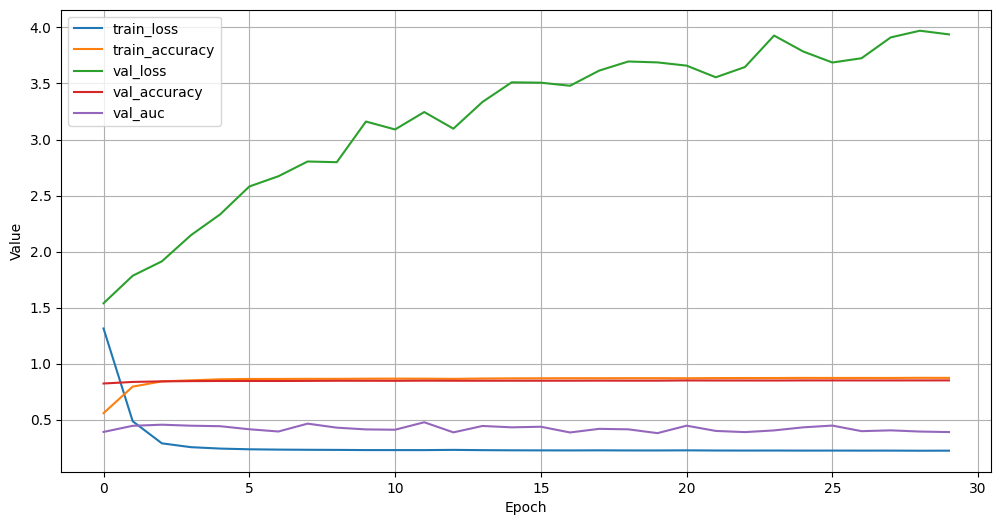

In [244]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))

    for metric, values in history.items():
        plt.plot(values, label=metric)

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_history(hist)

0.4362962245374244


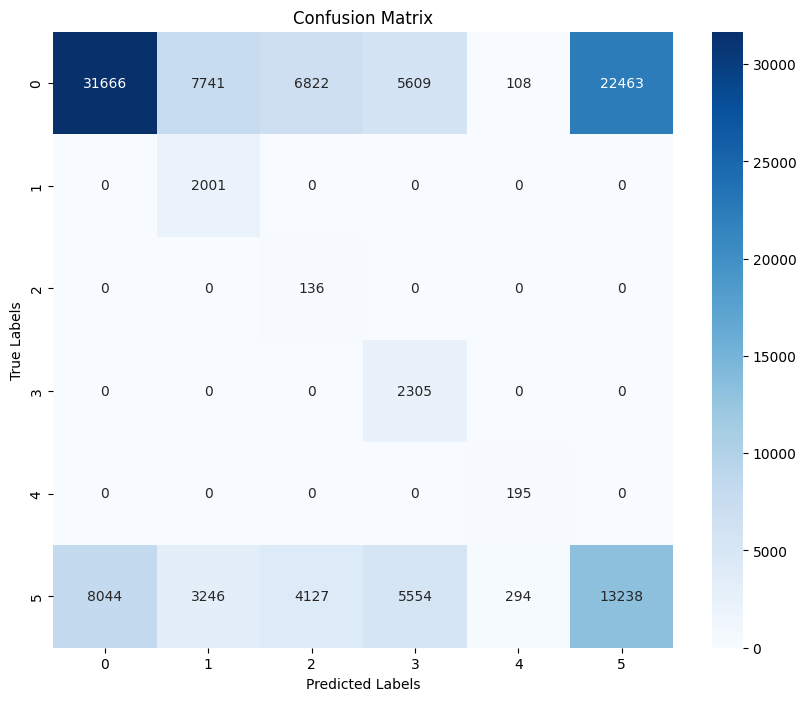

              precision    recall  f1-score   support

           0       0.80      0.43      0.55     74409
           1       0.15      1.00      0.27      2001
           2       0.01      1.00      0.02       136
           3       0.17      1.00      0.29      2305
           4       0.33      1.00      0.49       195
           5       0.37      0.38      0.38     34503

    accuracy                           0.44    113549
   macro avg       0.31      0.80      0.33    113549
weighted avg       0.64      0.44      0.49    113549



In [253]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def report(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    print(accuracy)
    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Plotting confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return report

# Assuming you have already trained your model and have a test loader
report = report(model, test_loader)
print(report)


In [52]:
class EarlyStopping:
    def __init__(self, tolerance):
        self.tolerance = tolerance
        self.counter = 0
        self.best_val_loss= 0
        self.early_stop = False

    def __call__(self, val_loss):
          if val_loss < self.best_val_loss:
              self.best_val_loss = val_loss
              self.counter = 0
          else:
              self.counter += 1
              if self.counter >= self.tolerance:
                  self.early_stop=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TO DO: Cast all dataframes to np.arrays or torch.tensors

def train(model, optimizer, num_epochs, l2_lambda):
    early_stopping = EarlyStopping(tolerance=20) # slow to learn, so it has to be VERY tolerant

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    current_fold_counter=0

    for train_index, val_index in kf.split(X_train): # temporarily discarding kfold to test on test set and have a baseline. Remember to reindent all under this

      current_fold_counter += 1

      early_stopping.early_stop = False
      early_stopping.counter = 0

      X_train_fold = X_train[train_index] #Recasted to a pd.DataFrame but ideally we should use np.ndarray everywhere
      y_train_fold = y_train[train_index]


      # Here I'm just trying to see if maybe I can reuse the entire test set with validation indexes from X_train without going out of bound.
      # I don't even know if this makes sense but that's the only thing that I could think as of right now
      #val_index_adjusted = val_index[val_index < len(X_test)]
      #X_val_fold = X_test[val_index_adjusted]
      #y_val_fold = y_test[val_index_adjusted]

      X_val_fold = X_train[val_index]
      y_val_fold = y_train[val_index]


      for epoch in range(num_epochs):
          model.train()
          out = model(torch.tensor(X_train_fold))
          y_train_fold_labels = np.argmax(y_train_fold, axis=1)
          loss = criterion(out, torch.tensor(y_train_fold_labels).long())

          ############## L2 Regularization ################
          parameters = torch.tensor([], device=device)
          parameters = torch.cat([param.view(-1) for param in model.parameters()], dim=0)

          l2_norm = torch.linalg.norm(parameters, 2).pow(2)
          loss = loss + l2_norm * l2_lambda

          #################################################

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          with torch.no_grad():
            val_outputs = model(X_val_fold)
            y_val_fold_labels = np.argmax(y_val_fold, axis=1)
            val_loss = criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
            _, val_preds = torch.max(val_outputs, 1)
            val_accuracy = (val_preds == torch.tensor(y_val_fold_labels)).sum().item() / len(y_val_fold_labels)
            train_preds = torch.argmax(out, 1)
            train_accuracy = (train_preds == torch.tensor(y_train_fold_labels)).sum().item() / len(y_train_fold_labels)


          print(f'Fold: {current_fold_counter}/{n_splits} - Epoch {epoch+1}/{num_epochs}')
          print(f'Train Loss: {loss.item()} - Validation Loss: {val_loss.item()} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}')

          train_losses.append(loss.item())
          val_losses.append(val_loss.item())
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)

          #early_stopping(val_loss.item())
          #if early_stopping.early_stop:
          #    print('Early stopping triggered...')
          #    break

      #if early_stopping.early_stop:
      #    break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [60]:
class EarlyStopping:
    def __init__(self, tolerance):
        self.tolerance = tolerance
        self.counter = 0
        self.best_val_loss= 0
        self.early_stop = False

    def __call__(self, val_loss):
          if val_loss < self.best_val_loss:
              self.best_val_loss = val_loss
              self.counter = 0
          else:
              self.counter += 1
              if self.counter >= self.tolerance:
                  self.early_stop=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TO DO: Cast all dataframes to np.arrays or torch.tensors

def train(model, optimizer, num_epochs, l2_lambda):
    early_stopping = EarlyStopping(tolerance=20) # slow to learn, so it has to be VERY tolerant

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    current_fold_counter=0

    for train_index, val_index in kf.split(X_train): # temporarily discarding kfold to test on test set and have a baseline. Remember to reindent all under this

      current_fold_counter += 1

      early_stopping.early_stop = False
      early_stopping.counter = 0

      X_train_fold = X_train.values[train_index] #Recasted to a pd.DataFrame but ideally we should use np.ndarray everywhere
      y_train_fold = y_train.values[train_index]


      # Here I'm just trying to see if maybe I can reuse the entire test set with validation indexes from X_train without going out of bound.
      # I don't even know if this makes sense but that's the only thing that I could think as of right now
      val_index_adjusted = val_index[val_index < len(X_test)]
      X_val_fold = X_test.values[val_index_adjusted]
      y_val_fold = y_test.values[val_index_adjusted]

      #X_val_fold = X_train.values[val_index]
      #y_val_fold = y_train.values[val_index]


      for epoch in range(num_epochs):
          model.train()
          out = model(torch.tensor(X_train_fold))
          y_train_fold_labels = np.argmax(y_train_fold, axis=1)
          loss = criterion(out, torch.tensor(y_train_fold_labels).long())

          ############## L2 Regularization ################
          parameters = torch.tensor([], device=device)
          parameters = torch.cat([param.view(-1) for param in model.parameters()], dim=0)

          l2_norm = torch.linalg.norm(parameters, 2).pow(2)
          loss = loss + l2_norm * l2_lambda

          #################################################

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          with torch.no_grad():
            val_outputs = model(X_val_fold)
            y_val_fold_labels = np.argmax(y_val_fold, axis=1)
            val_loss = criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
            _, val_preds = torch.max(val_outputs, 1)
            val_accuracy = (val_preds == torch.tensor(y_val_fold_labels)).sum().item() / len(y_val_fold_labels)
            train_preds = torch.argmax(out, 1)
            train_accuracy = (train_preds == torch.tensor(y_train_fold_labels)).sum().item() / len(y_train_fold_labels)


          print(f'Fold: {current_fold_counter}/{n_splits} - Epoch {epoch+1}/{num_epochs}')
          print(f'Train Loss: {loss.item()} - Validation Loss: {val_loss.item()} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}')

          train_losses.append(loss.item())
          val_losses.append(val_loss.item())
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)

          #early_stopping(val_loss.item())
          #if early_stopping.early_stop:
          #    print('Early stopping triggered...')
          #    break

      #if early_stopping.early_stop:
      #    break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [61]:
EPOCHS = 50# to have 500 epochs, using 20 for convenience

train_loss, val_loss, train_accuracy, val_accuracy = train(model, optimizer, num_epochs=EPOCHS, l2_lambda=0.01)

RuntimeError: ignored

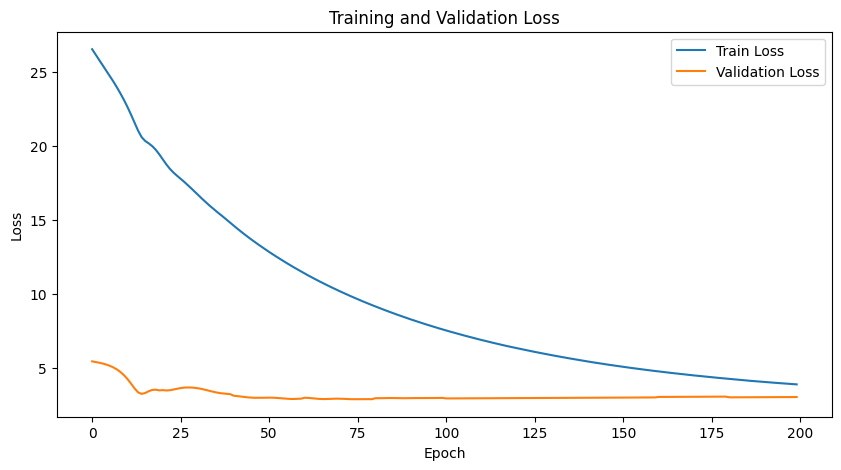

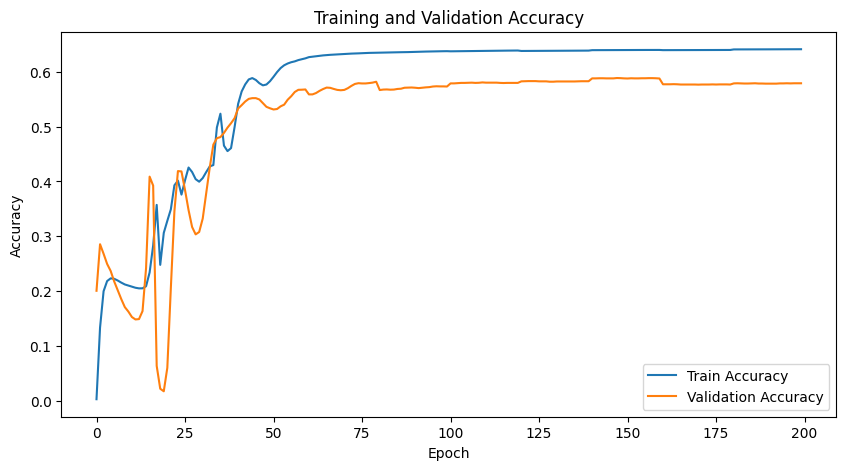

In [ ]:


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:

if running_local:
    PATH = "model/model.pth"
else:
    PATH = "drive/MyDrive/StructuralBioinformatics/model/model.pth"

In [ ]:
torch.save(model, PATH)

In [ ]:
# Load Model For Inference

model = torch.load(PATH)
model.eval()

ContactNet(
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=128, bias=True)
    (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=256, bias=True)
    (6-7): 2 x Linear(in_features=256, out_features=256, bias=True)
    (8): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [ ]:
# Convert your test dataset into PyTorch tensors
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values).long()

# Create a DataLoader for your test set
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=32)

In [219]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)

        # Get predicted class indices
        _, preds = torch.max(outputs, 1)

        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

y_pred_oneHot = pd.get_dummies(y_pred).values
print(classification_report(y_true, y_pred_oneHot, target_names = cat_names))

ValueError: ignored

In [218]:
cm = confusion_matrix(np.argmax(y_true,axis=1), y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_names)
cm_display.plot(cmap='Blues', ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Actual Contact')
plt.xlabel('Predicted Contact')
plt.show()

NameError: ignored